In [1]:
import cv2
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import mlflow
import mlflow.tensorflow
from mlflow import MlflowClient
from skimage.io import imshow
import imageio

Segmentation Models: using `tf.keras` framework.


In [2]:
def display_hsv(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    fig, arr = plt.subplots(1, 3, figsize=(14, 10))
    arr[0].imshow(image_hsv[:, :, 0], cmap='hsv')
    arr[0].set_title('Hue')
    arr[1].imshow(image_hsv[:, :, 1], cmap='hsv')
    arr[1].set_title('Saturation')
    arr[2].imshow(image_hsv[:, :, 2], cmap='hsv')
    arr[2].set_title('Value')
    
    fig.show()

def display_rgb(image):
    
    fig, arr = plt.subplots(1, 3, figsize=(14, 10))
    arr[0].imshow(image[:, :, 0])
    arr[0].set_title('R')
    arr[1].imshow(image[:, :, 1])
    arr[1].set_title('G')
    arr[2].imshow(image[:, :, 2])
    arr[2].set_title('B')

    fig.show()

In [3]:
def extract_AV_mask(img):
    
    R = img[:, :, 0]
    B = img[:,:, 2]
    diff = R - B

    artery_mask = diff > 0.1
    vein_mask = diff < -0.1
    ves_mask = np.logical_or(artery_mask, vein_mask)

    # Create an empty RGB image
    height, width = artery_mask.shape
    av_mask = np.zeros((height, width, 3), dtype=np.float32)

    av_mask[artery_mask, 0] = 1   # set as red
    av_mask[vein_mask, 2] = 1     # set as blue
    overlap = (artery_mask) & (vein_mask)
    av_mask[overlap, 1] = 1       # set as green
    # Zero out the red and blue channels in overlapping regions to ensure green is the only color
    av_mask[overlap, 0] = 0
    av_mask[overlap, 2] = 0
    
    return artery_mask, vein_mask, ves_mask, av_mask

# Function to crop the circular region tightly
def crop_and_pad_to_square(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Convert to 8-bit single-channel image
    gray_8bit = cv2.convertScaleAbs(gray, alpha=(255.0))

    # Apply a threshold to separate the circle from the background
    _, thresh = cv2.threshold(gray_8bit, 10, 255, cv2.THRESH_BINARY)

    # Find contours (edges of the circular region)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Get the largest contour, which should correspond to the circular region
    contour = max(contours, key=cv2.contourArea)

    # Get the bounding box of the circle
    x, y, w, h = cv2.boundingRect(contour)

    # Crop the image to the bounding box
    cropped_image = image[y:y+h, x:x+w]

    # Get the dimensions of the cropped image
    cropped_height, cropped_width = cropped_image.shape[:2]

    # Calculate padding to make it square
    if cropped_width > cropped_height:
        padding = (cropped_width - cropped_height) // 2
        padded_image = cv2.copyMakeBorder(cropped_image, padding, padding, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    elif cropped_height > cropped_width:
        padding = (cropped_height - cropped_width) // 2
        padded_image = cv2.copyMakeBorder(cropped_image, 0, 0, padding, padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])
    else:
        padded_image = cropped_image  # Already square

    return padded_image



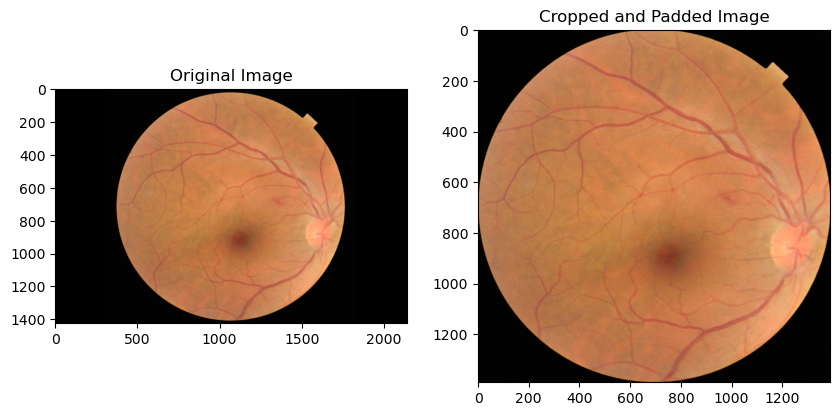

In [4]:
# Function to crop and pad the circular region to make it square using TensorFlow
def crop_and_pad_to_square_tf(image):
    # Convert the image to grayscale (keep the last dimension for compatibility)
    gray = tf.image.rgb_to_grayscale(image)

    # Ensure the grayscale image is in float32 format before scaling
    gray_float = tf.cast(gray, tf.float32)

    # Convert grayscale image to uint8
    gray_uint8 = tf.cast(gray_float * 255.0, tf.uint8)

    # Apply a threshold to separate the circle from the background
    binary_mask = tf.where(gray_uint8 > 25, 1.0, 0.0)  # Use a threshold of 25 for uint8

    # Find the non-zero elements in the mask (this is equivalent to finding contours)
    non_zero_indices = tf.where(binary_mask[..., 0] > 0)
    
    # Get the bounding box of the non-zero region
    top_left = tf.reduce_min(non_zero_indices, axis=0)
    bottom_right = tf.reduce_max(non_zero_indices, axis=0)
    
    # Crop the image to the bounding box
    cropped_image = image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1], :]
    
    # Get the dimensions of the cropped image and cast them to int32
    cropped_height = tf.cast(bottom_right[0] - top_left[0], tf.int32)
    cropped_width = tf.cast(bottom_right[1] - top_left[1], tf.int32)
    
    # Calculate the amount of padding needed to make the image square
    if cropped_width > cropped_height:
        padded_image = tf.image.resize_with_crop_or_pad(cropped_image, cropped_width, cropped_width)
    elif cropped_height > cropped_width:
        padded_image = tf.image.resize_with_crop_or_pad(cropped_image, cropped_height, cropped_height)
    else:
        padded_image = cropped_image  # Already square

    return padded_image

img_path = '/Users/chunduri/Desktop/CVD Project/Datasets/Aditya/Data/Input_Image/10.png'
image_raw = tf.io.read_file(img_path)

# Decode the image to a tensor (assuming it's a JPEG image)
image_tensor = tf.image.decode_png(image_raw, channels=3)

# Optionally, convert it to float32 for further processing
image_tensor = tf.image.convert_image_dtype(image_tensor, dtype=tf.float32)

# Test the crop_and_pad_to_square_tf function on the single image tensor
cropped_image = crop_and_pad_to_square_tf(image_tensor)

# Convert cropped image back to numpy for visualization
cropped_image_np = cropped_image.numpy()

# Visualize the original and cropped images
plt.figure(figsize=(10, 5))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(image_tensor)
plt.title("Original Image")

# Display cropped image
plt.subplot(1, 2, 2)
plt.imshow(cropped_image_np)
plt.title("Cropped and Padded Image")

plt.show()

In [ ]:
# One example 
img_path = '../data/RFI_Dataset/EYEPACS/V02/train/Original/104_left.png'
av_path = '../data/RFI_Dataset/EYEPACS/V02/train/AV_prediction/104_left.png'
ves_path = '../data/RFI_Dataset/FIVES Dataset/test/Ground truth/1_A.png'


img_five = mpimg.imread(img_path)
img_five = crop_and_pad_to_square(img_five)



# img_five = tf.image.resize(img_five, (512,512), method='nearest')
img_five = tf.constant(img_five).numpy()

ves_five = mpimg.imread(ves_path)
av_five = mpimg.imread(av_path)
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])


fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img_five)
arr[0].set_title('Image')
arr[1].imshow(av_five)
arr[1].set_title('AV Segmentation')

In [5]:
A_mask, V_mask, overlap, AV_mask = extract_AV_mask(av_five)

fig, arr = plt.subplots(1, 5, figsize=(14, 14))
arr[0].imshow(av_five)
arr[0].set_title('A/V')

arr[1].imshow(A_mask, cmap ='gray')
arr[1].set_title('Artery')

arr[2].imshow(V_mask, cmap ='gray')
arr[2].set_title('Vein')

arr[3].imshow(overlap, cmap ='gray')
arr[3].set_title('combine')

arr[4].imshow(AV_mask, cmap ='gray')
arr[4].set_title('vessel')



NameError: name 'av_five' is not defined

In [ ]:
print(np.min(av_five), np.max(av_five))

In [ ]:
display_rgb(av_five)

In [ ]:
av_five.max()

In [ ]:
fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(av_five)
arr[0].set_title('A/V')
arr[1].imshow(ves_five)
arr[1].set_title('Vessel Ground truth')


In [ ]:
artery_mask, vein_mask, ves_mask, av_mask= extract_AV_mask(av_five)

fig, arr = plt.subplots(1, 3, figsize=(14, 10))
arr[0].imshow(av_five)
arr[0].set_title('A/V')
arr[1].imshow(ves_mask)
arr[1].set_title('Vessel mask')
arr[2].imshow(av_mask)
arr[2].set_title('A/V mask')

In [ ]:
# Genearte AV masks to fine-tune the UNet
IMG_DIR = img_path = '../data/RFI_Dataset/FIVES Dataset/train/Original/'
AV_PRED_DIR = '../data/RFI_Dataset/FIVES Dataset/train/AV_prediction/'
VES_DIR = '../data/RFI_Dataset/FIVES Dataset/train/Ground truth/'

OUT_IMG_DIR = '../data/RFI_Dataset/FIVES Dataset/train/processed_Original/'
OUT_VES_DIR = '../data/RFI_Dataset/FIVES Dataset/train/processed_Ground_truth/'
OUT_AV_DIR = '../data/RFI_Dataset/FIVES Dataset/train/processed_AV_prediction/'

def check_make_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print(f'Directory "{dir}" created.')
    else:
        print(f'Directory "{dir}" already exists.')

check_make_dir(OUT_IMG_DIR)
check_make_dir(OUT_VES_DIR)
check_make_dir(OUT_AV_DIR)

processed_image = sorted(os.listdir(AV_PRED_DIR))


In [ ]:
PROCESS_NUM = len([f for f in os.listdir(AV_PRED_DIR) if os.path.isfile(os.path.join(AV_PRED_DIR, f))])
PROCESS_NUM

In [ ]:


for i in range(PROCESS_NUM):
    
    # Load AV segmentation results processed by 'https://retinavessel.com/'
    filename = processed_image[i]
    raw_img_path = os.path.join(IMG_DIR, filename)
    ves_img_path = os.path.join(VES_DIR, filename)
    av_pred_path = os.path.join(AV_PRED_DIR, filename)
    
    # print(raw_img_path)
    # print(av_pred_path)
    # print(ves_img_path)
    
    img_five = mpimg.imread(raw_img_path)
    img_five = cv2.convertScaleAbs(img_five, alpha=255)
    img_five = tf.convert_to_tensor(img_five, dtype=tf.float32) / 255.0
    img_five = tf.image.resize(img_five, (512, 512), method='nearest')
    img_five = tf.constant(img_five).numpy()


    av_five = mpimg.imread(av_pred_path)
    av_five = cv2.convertScaleAbs(av_five, alpha=255)
    av_five = tf.convert_to_tensor(av_five, dtype=tf.float32) / 255.0
    av_five = tf.image.resize(av_five, (512, 512), method='nearest')
    av_five = tf.constant(av_five).numpy()

    ves_five = mpimg.imread(ves_img_path)
    ves_five = cv2.convertScaleAbs(ves_five, alpha=255)
    ves_five = tf.convert_to_tensor(ves_five, dtype=tf.float32) / 255.0
    ves_five = tf.image.resize(ves_five, (512, 512), method='nearest')
    ves_five = tf.constant(ves_five).numpy()


    # Extract masks
    artery_mask, vein_mask, ves_mask, av_mask= extract_AV_mask(av_five)

    

    # Output results
    image_path = OUT_IMG_DIR + filename[:-4] + ".png"
    vessel_mask_path = OUT_VES_DIR + filename[:-4] + ".png"
    av_mask_path = OUT_AV_DIR + filename[:-4] + ".png"


    # print(image_path)
    # print(vessel_mask_path)
    # print(av_mask_path)
    
    mpimg.imsave(image_path, img_five)
    mpimg.imsave(vessel_mask_path, ves_mask, cmap='gray')
    mpimg.imsave(av_mask_path, av_mask)

    if i%10 == 0:
        print(i)



In [17]:
img_five = mpimg.imread(raw_img_path)
cvtImg = cv2.convertScaleAbs(img_five, alpha=255)

In [ ]:
np.max(cvtImg)
# plt.imshow(cvtImg)

In [ ]:
plt.imshow(img_five)